# Module 1 Project: King County House Sales Price Projection


#### Follow the OSEMN model process in this project:

-   Obtain
-   Scrub
-   Explore
-   Model
-  Interpret

# I. Obtain the data 


In [1]:
#import libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.formula.api as smf
import scipy.stats as stats
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline



In [2]:
kcdata = pd.read_csv("kc_house_data.csv")

In [3]:
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
kcdata.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# II. Data Scrubbing



* Identify and deal with null values appropriately
* Cast columns to the appropriate data types
* Remove unnecessary columns
* Check for and deal with multicollinearity
* Normalize our data

### Deal with missing values

In [5]:
#Identify missing value: waterfront, view, yr_renovated, and incorrect data type: sqft_basement
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [6]:
kcdata.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
#For Categorical data 'Waterfront', replace NAN with mode 0 since it is highly possible that the house doesn't have a waterfront. 
kcdata['waterfront'].value_counts()
kcdata['waterfront'] = kcdata['waterfront'].fillna(0)

counter = Counter()
counter = Counter(kcdata['waterfront'])
print(counter)

Counter({0.0: 21451, 1.0: 146})


For view, this variable presents how many times people have viewed the house. Majority of the values are zero. So we will replace NAN with 0.

In [8]:
kcdata['view'].unique()
kcdata['view'] = kcdata['view'].fillna(0)
counter = Counter()
counter = Counter(kcdata['view'])
print(counter)


Counter({0.0: 19485, 2.0: 957, 3.0: 508, 1.0: 330, 4.0: 317})


In [9]:
#There are too many missing values in yr_renovated. And it may not be fair to replace NAN with average. 
#So we will probably not consider this variable into the model.We will fill NaN and remove this column now.
%matplotlib inline
kcdata['yr_renovated'].fillna(0);

In [10]:
kcdata.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [11]:
kcdata.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Cast columns to the appropriate data types

Obvious fix: change date from string to datetime, sqft_basement to continuous, waterfront as categorical

Condition and grade are ordinal variables with limited values. View and Floors have limited values too. Can group them into bins. 

In [12]:
#Convert strings into dates
from datetime import datetime
kcdata['date'].head()
f = lambda x: datetime.strptime(x,'%m/%d/%Y')
kcdata['date']=kcdata['date'].apply(f)
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [13]:
#Convert sqft_basement column from string to numerical
kcdata['sqft_basement'].value_counts()

#Replace ? with zeros for now.
kcdata['sqft_basement'] = kcdata['sqft_basement'].replace('?','0')


kcdata['sqft_basement'] = kcdata['sqft_basement'].astype(float)
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(11)
memory usage: 3.5

## III. Data Exploration

From the data dictionary below we can probably tell some are continuous variables (footage of the home/lot/basement/yr_built) and some might be numerical but more like categorical (number of bathrooms/bedrooms, waterfront, view, condition, grade), and other variables we are not sure (zipcode,lat,long). We will visualize them next.

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

#### House Price change over Time

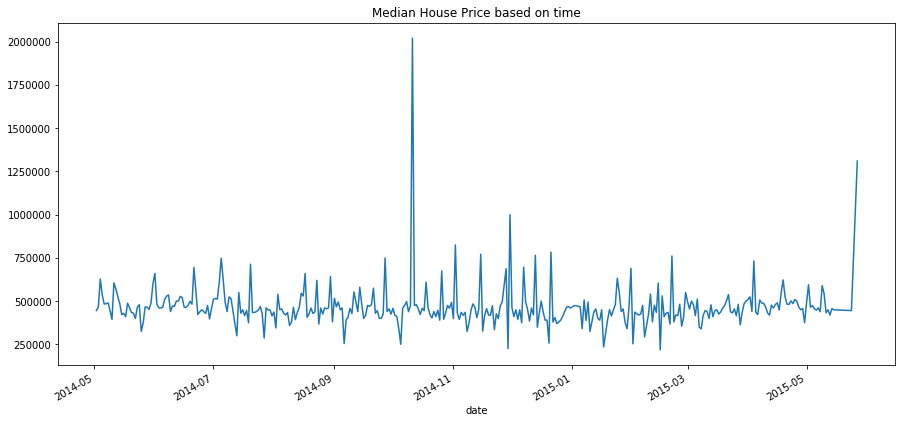

In [14]:
temp = kcdata['price'].groupby([kcdata['date']]).median()
temp.index = pd.to_datetime(temp.index)
temp.plot(figsize=(15,7),title='Median House Price based on time')
plt.show()

#### Areas with top house price

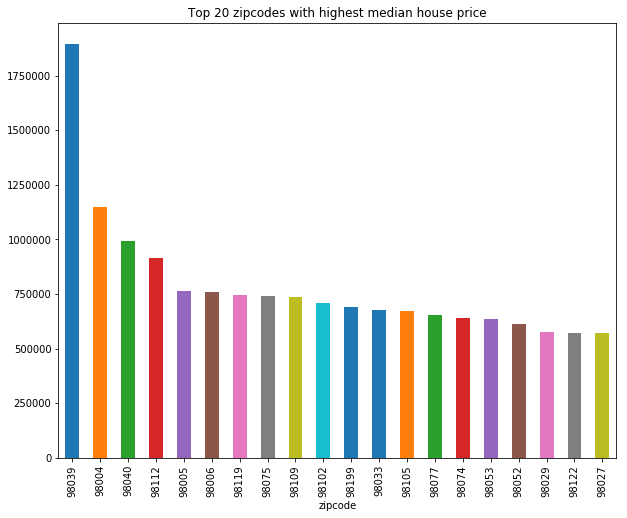

In [15]:
temp = kcdata['price'].groupby([kcdata['zipcode']]).median()
temp = temp.sort_values(ascending=False)[:20]
temp.plot(kind='bar',figsize=(10,8), title='Top 20 zipcodes with highest median house price')
plt.show()

<img src='map.png'>

In [16]:
kcdata['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

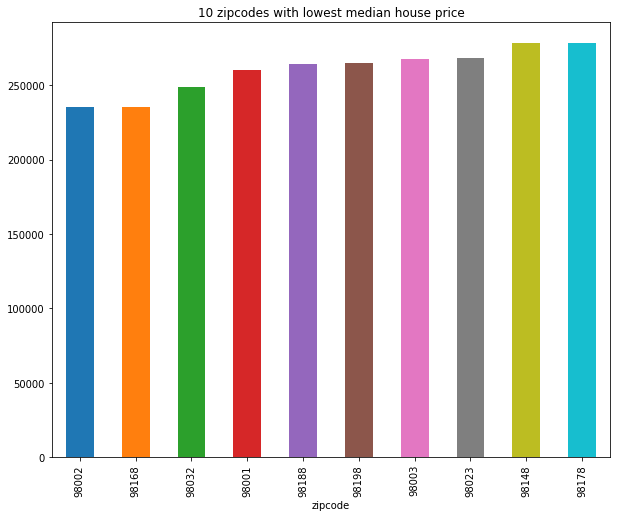

In [17]:
temp = kcdata['price'].groupby([kcdata['zipcode']]).median()
temp = temp.sort_values(ascending=True)[:10]
temp.plot(kind='bar',figsize=(10,8), title='10 zipcodes with lowest median house price')
plt.show()

In [18]:
kcdata['price'].groupby([kcdata['zipcode']]).mean();

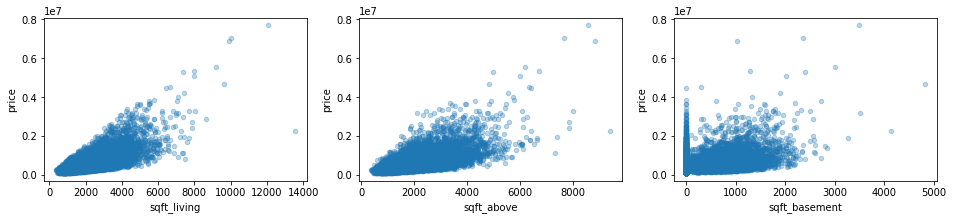

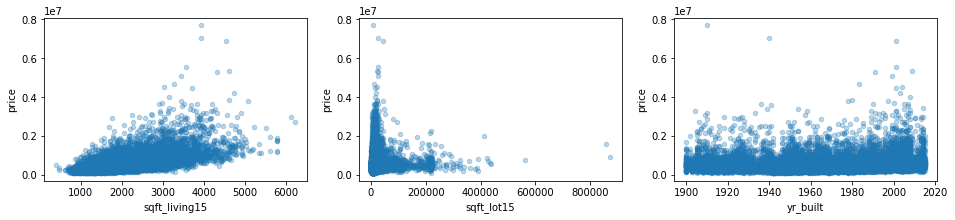

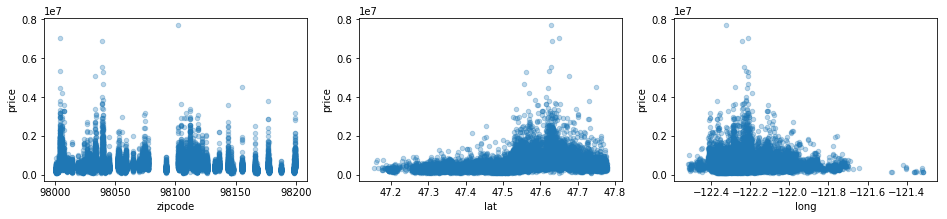

In [19]:
#Plotting potential continuous variables

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list = ['sqft_living','sqft_above','sqft_basement']

for xcol, ax in zip(con_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list2 =['sqft_living15','sqft_lot15','yr_built']

for xcol, ax in zip(con_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)
    
#Plotting zipcode

fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,3))
geo_list = ['zipcode','lat','long']

for xcol, ax in zip(geo_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)


Observation: From the scattered plots above, we can tell sqft_living, sqft_above, sqft_living15 have positive correlation with house price, while yr_built and zipcode do not have obvious relationship with house price. Also from the plot, we can tell that the shape of sqft_living and sqft_living15 are similar while sqft_lot and sqft_lot15 are very similar too. So probably these two sets of variables are highly correlated.

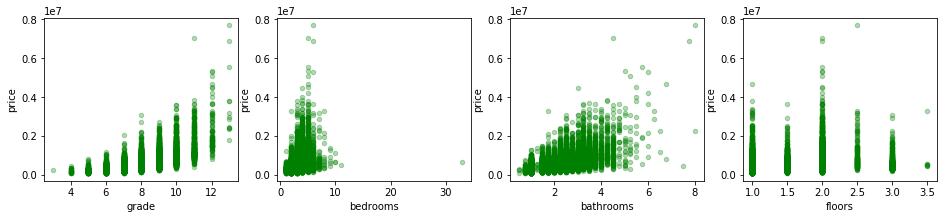

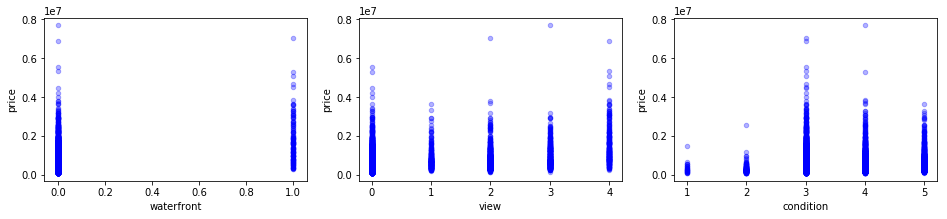

In [20]:
#Plotting other variables. Waterfront is clearly categorical values with binominal values. 
#While view, condition, grade, bedrooms, bathrooms, and floors present actual numerical values so we can either keep them numerical or transform them into categorical values. 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
cat_list1 = ['grade','bedrooms', 'bathrooms','floors']


for xcol, ax in zip(cat_list1, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='g')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))    
cat_list2=['waterfront', 'view', 'condition']
for xcol, ax in zip(cat_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='b')

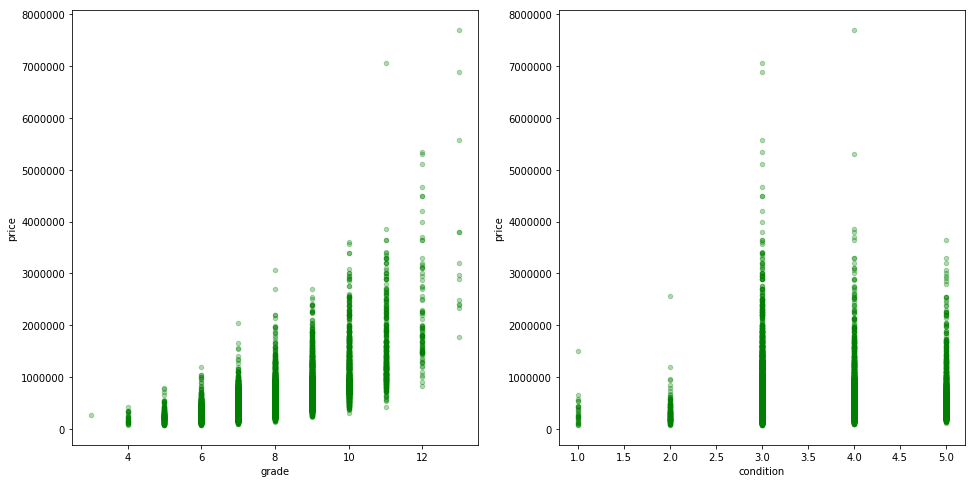

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
cat_list1 = ['grade','condition']


for xcol, ax in zip(cat_list1, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='g')



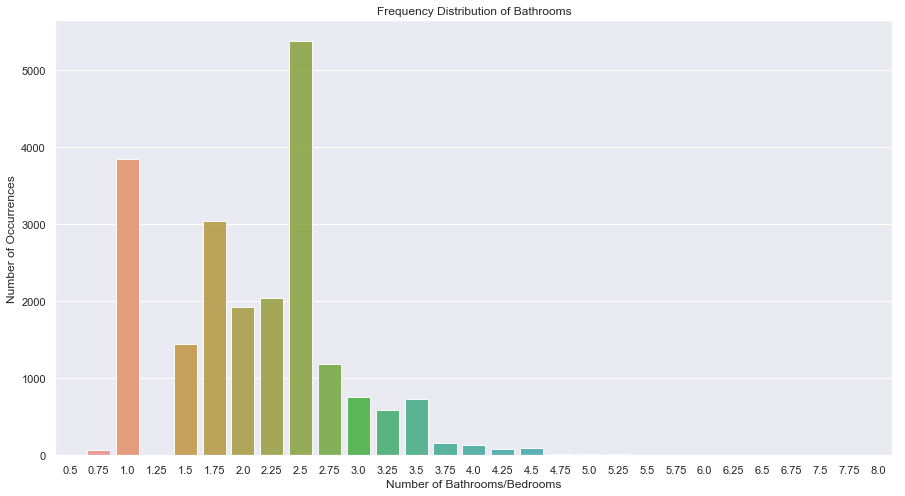

In [22]:
#Value Counts 
#bathroomsNumber - of bathrooms/bedrooms

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
bathroom_count = kcdata['bathrooms'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.barplot(bathroom_count.index, bathroom_count.values, alpha=0.9)

plt.title('Frequency Distribution of Bathrooms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Bathrooms/Bedrooms', fontsize=12)
plt.show()

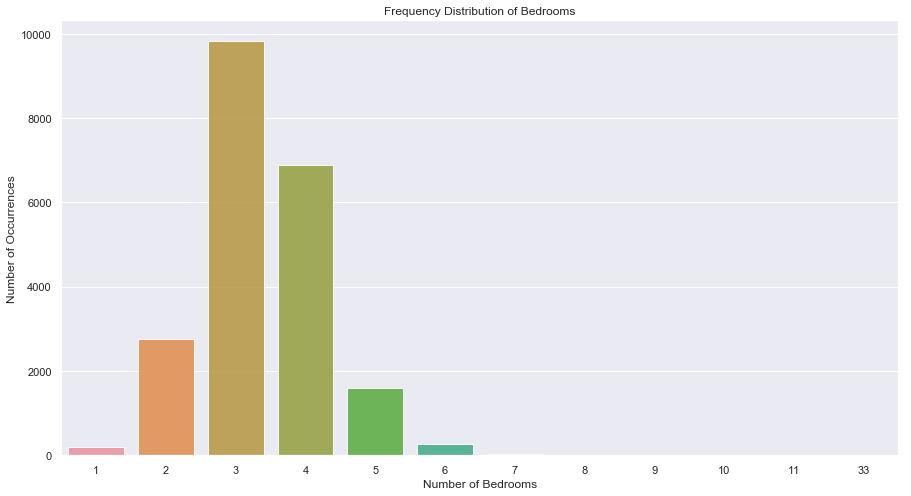

In [23]:
bedroom_count = kcdata['bedrooms'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.barplot(bedroom_count.index, bedroom_count.values, alpha=0.9)

plt.title('Frequency Distribution of Bedrooms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Bedrooms', fontsize=12)
plt.show()

#### Outliers in Bedroom

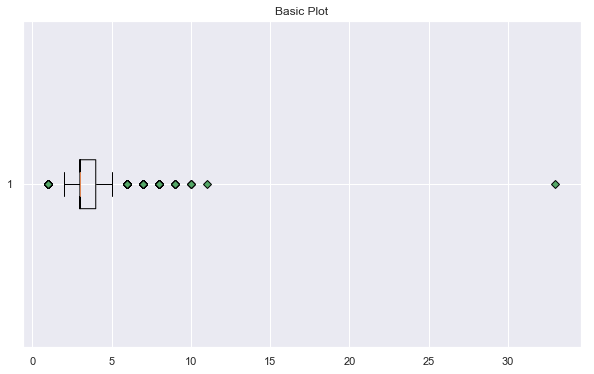

In [24]:
fig1, ax1 = plt.subplots(figsize=(10,6))
green_diamond = dict(markerfacecolor='g', marker='D')
ax1.set_title('Basic Plot')
ax1.boxplot(kcdata['bedrooms'], notch=True, flierprops=green_diamond, vert=False)
plt.show()

We should at least remove the far right point.

## Correlation Matrix

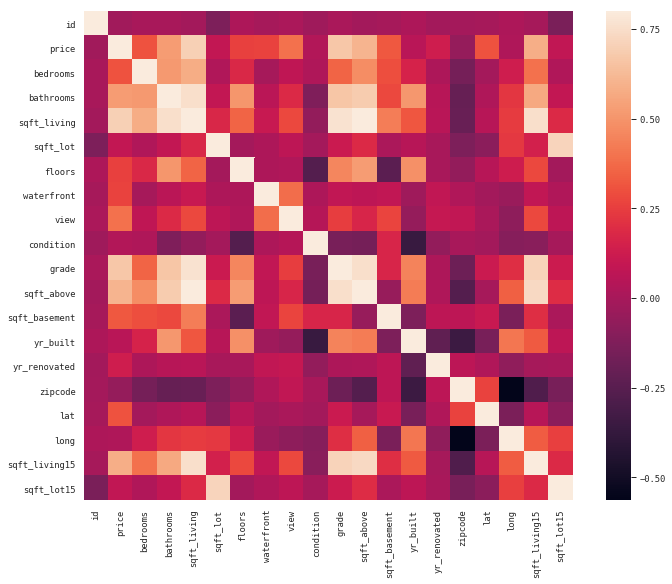

In [25]:
sns.set(context='paper', font='monospace')
corrmat = kcdata.corr()


f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.8, square=True);

Analyzing the heatmap, the variables that are highly correlated to price are:
* sqft_living
* sqft_above
* grade

Independent variables which are highly correlated with each other:

* sqft_living with sqft_living15, bathroom, grade, sqft_above
* grade with bathroom, sqft_above, sqft_living15, sqft_living

## Check Multicolinearity 

In [26]:
## Check Multicolinearity 

kcdata_set = kcdata.iloc[:,3:-1]
kcdata_set.head()
kcdata_set.corr()
abs(kcdata_set.corr()) > 0.75

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
grade,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False


The correlation matrix confirms the observation that sqft_living are highly correlated with bathrooms, grade, sqft_above, sqft_living15.

Multicolinearity exists here.

We will drop sqft_living15, sqft_lot15 because they are highly correlated with sqft_living and sqft_lot, and also zipcode, lat, long.

### Turn view to binary variable

In [27]:
kcdata['view']=kcdata['view'].fillna(0)
kcdata['view'] = kcdata['view'].astype(int)

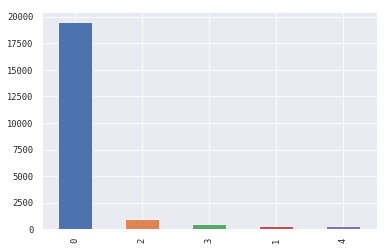

In [28]:
kcdata['view'].value_counts().plot(kind='bar')

In [29]:
kcdata['view'].describe()

count    21597.000000
mean         0.233181
std          0.764673
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

Since more than 75% values are 0, it might make sense to create a binary variable "viewed".

In [30]:
kcdata['viewed'] = pd.Series(len(kcdata['price']), index=kcdata.index)
kcdata['viewed'] = 0
kcdata.loc[kcdata['view']>0,'viewed']=1
viewed_dummy = pd.get_dummies(kcdata['viewed'], prefix ='view')

## Turn condition to dummy columns

(-0.5, 4.5, 0, 8000000)

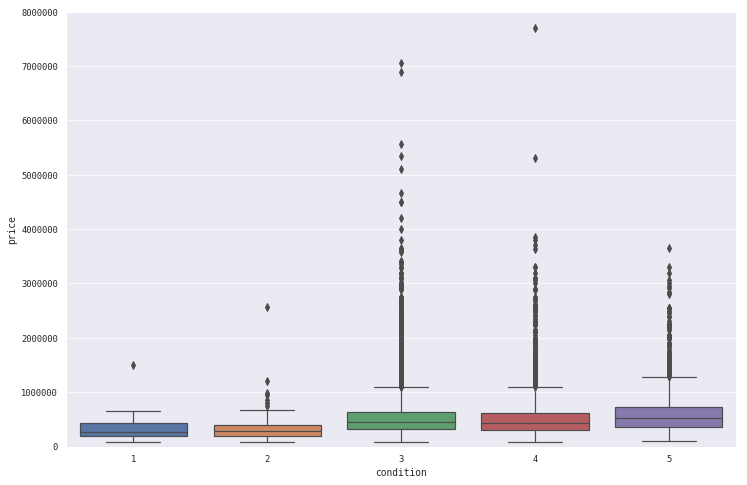

In [31]:
data = pd.concat([kcdata['price'], kcdata['condition']], axis=1)
f, ax = plt.subplots(figsize=(12,8))
fig = sns.boxplot(x='condition', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

In [32]:
condition_dummies = pd.get_dummies(kcdata['condition'], prefix='con')

In [33]:

condition_dummies.head(10)

,con_1,con_2,con_3,con_4,con_5
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,1,0,0
7,0,0,1,0,0
8,0,0,1,0,0
9,0,0,1,0,0


## Convert Waterfront to binominal 

In [34]:
waterfront_dummy = pd.get_dummies(kcdata['waterfront'], prefix ='waterfront')

## Explore grade, bedrooms, bathrooms, years and floors

Although grade, bedrooms, bathrooms and floors are numerical values, it is diffidult to justify a linear pattern between these variables and target here. For example, grade 2 may not mean it is twice better than grade 1, or worse. It might make sense to restructure data into bins so that they are treated as categorical variables.

#### GRADE

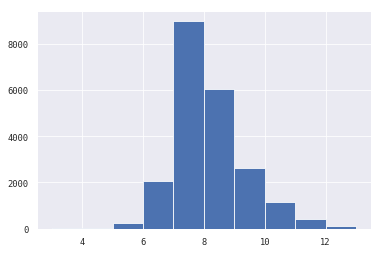

In [35]:
kcdata['grade'].describe()
kcdata['grade'].hist()

(-0.5, 10.5, 0, 8000000)

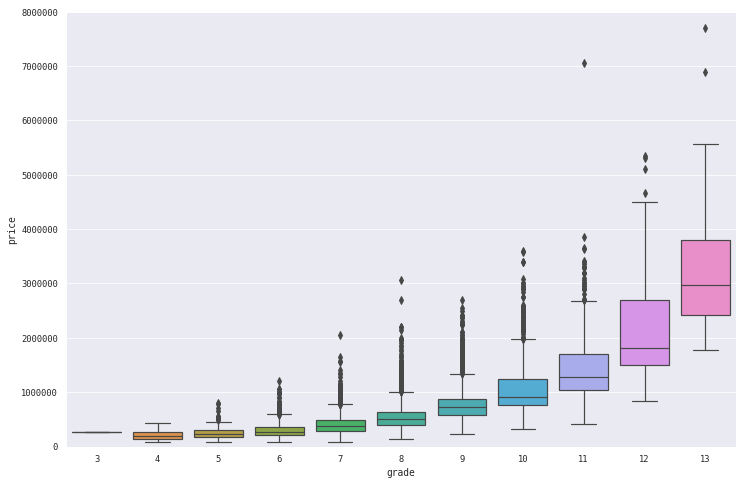

In [36]:
data = pd.concat([kcdata['price'], kcdata['grade']], axis=1)
f, ax = plt.subplots(figsize=(12,8))
fig = sns.boxplot(x='grade', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

Boxplot shows obvious exponential relationship between grade and price. We will keep all grades and create dummy variables.

In [37]:
grade_dummy = pd.get_dummies(kcdata['grade'], prefix='grade')

#### BEDROOMS

In [38]:
kcdata['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

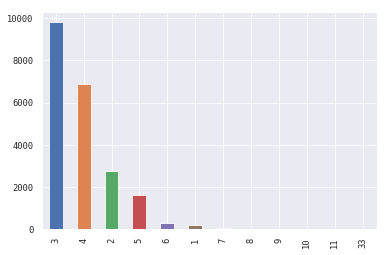

In [39]:
kcdata['bedrooms'].value_counts().plot(kind='bar')

There might be an outlier 33 in the bedroom variable. 

In [40]:
#The observation doesn't make sense, a house with 33 bedrooms only have 1040 sqft above the basement.
kcdata[kcdata['bedrooms']==33].sqft_above

15856    1040
Name: sqft_above, dtype: int64

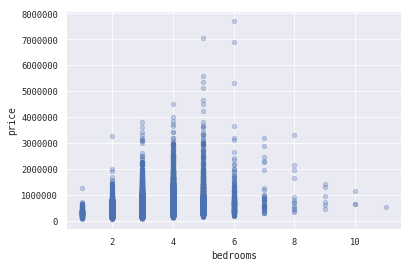

In [41]:
#Remove the max value from bedrooms
o = kcdata['bedrooms'].max()
kcdata = kcdata[kcdata['bedrooms']< o]
kcdata.plot(kind='scatter', x='bedrooms', y='price', alpha=0.3, color='b');


(-0.5, 10.5, 0, 8000000)

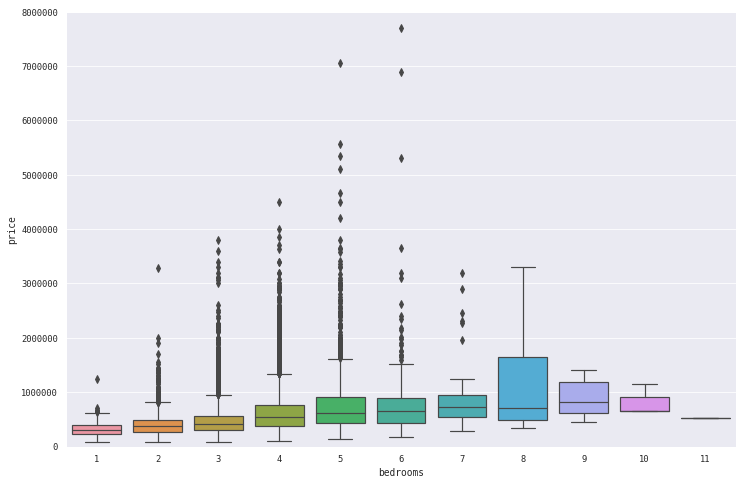

In [42]:

data = pd.concat([kcdata['price'], kcdata['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(12,8))
fig = sns.boxplot(x='bedrooms', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

In [43]:
kcdata['bedrooms'].describe()

count    21596.000000
mean         3.371828
std          0.904114
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64

In [44]:
bins = [1,2,3,4,5,6,11]
bins_bedroom = pd.cut(kcdata['bedrooms'],bins)
bins_bedroom = bins_bedroom.cat.as_unordered()
bedroom_dummy = pd.get_dummies(bins_bedroom, prefix='bedroom')

#### BATHROOMS

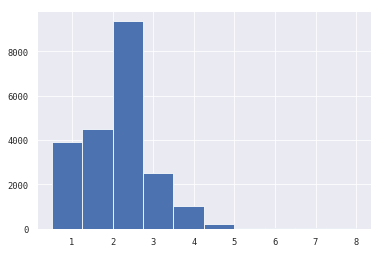

In [45]:
kcdata['bathrooms'].hist()
#kcdata['bathrooms'].value_counts();

The definition of 'bathrooms' is the number of bathrooms per bedrooms. Normally a residential building have 0.5-2 bathrooms per bedroom. So 3-8 bathrooms per bedroom may suggest there are different kinds of buildings. We can investigate the sqft_above and price to see if any outliers. 

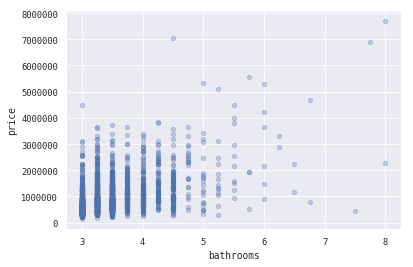

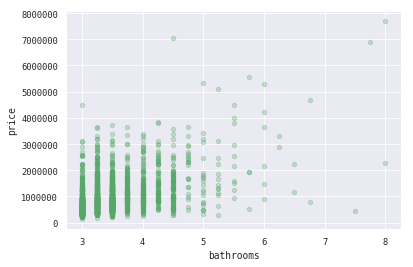

In [46]:
kcdata[kcdata['bathrooms']>=3].groupby('bathrooms').sqft_above.mean()
b = kcdata[kcdata['bathrooms']>=3]
b.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='b')
b.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


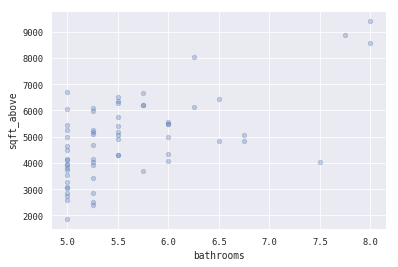

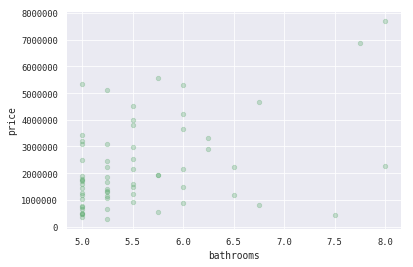

In [47]:
#Check bathrooms >5. 
kcdata[kcdata['bathrooms']>=5].groupby('bathrooms').sqft_above.mean()
a = kcdata[kcdata['bathrooms']>= 5]
a.plot(kind='scatter', x='bathrooms', y='sqft_above', alpha=0.3, color='b')
a.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


We will create bins for bathrooms for now. 

In [48]:
bins = [0.5,1.5,2,2.5,5,8]
bins_bathroom = pd.cut(kcdata['bathrooms'],bins)
bins_bathroom = bins_bathroom.cat.as_unordered()
bathroom_dummy = pd.get_dummies(bins_bathroom, prefix='bathroom')

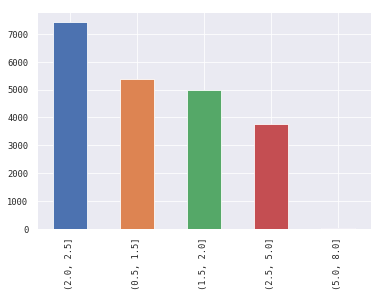

In [49]:
bins_bathroom.value_counts().plot(kind='bar')

#### FLOORS

In [50]:
kcdata['floors'].describe()

count    21596.000000
mean         1.494119
std          0.539685
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [51]:
bins = [0,1,1.5,2,3.5]
bins_floors = pd.cut(kcdata['floors'],bins)
bins_floors = bins_floors.cat.as_unordered()
floors_dummy = pd.get_dummies(bins_floors, prefix = 'floors')

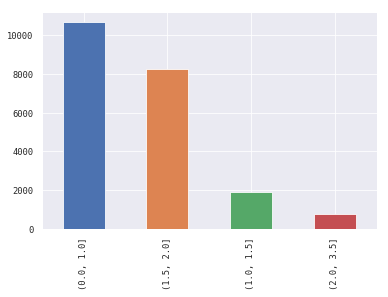

In [52]:
bins_floors.value_counts().plot(kind='bar')

#### Year Built

In [53]:
kcdata['yr_built'].describe()

count    21596.000000
mean      1971.000787
std         29.375460
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

(-0.5, 115.5, 0, 8000000)

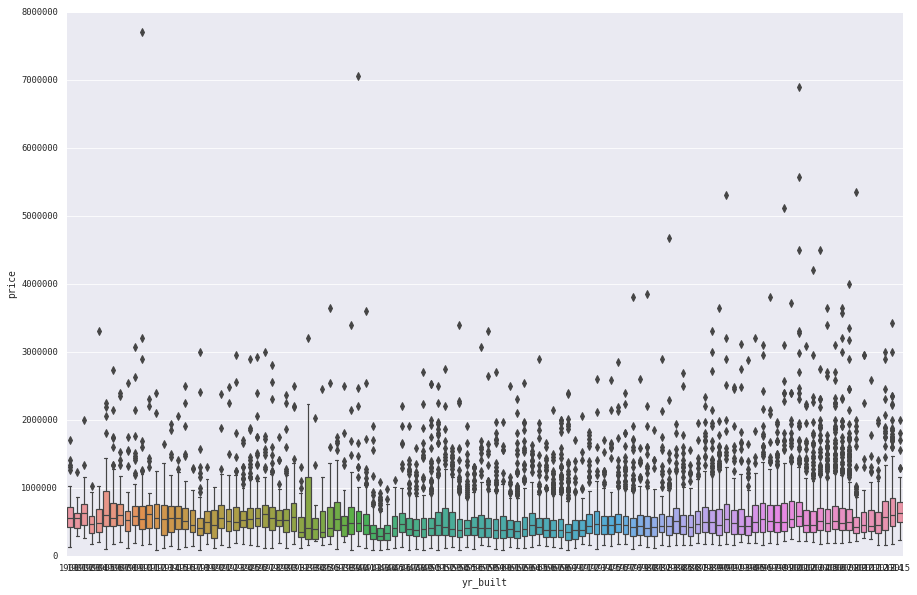

In [54]:
data = pd.concat([kcdata['price'], kcdata['yr_built']], axis=1)
f, ax = plt.subplots(figsize=(15,10))
fig = sns.boxplot(x='yr_built', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

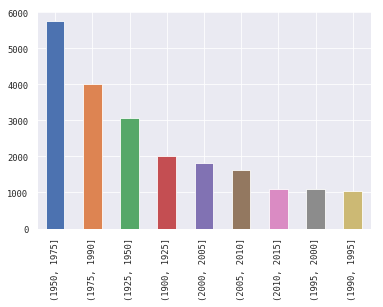

In [55]:
bins = [1900,1925,1950,1975,1990,1995,2000,2005,2010, 2015]
bins_year = pd.cut(kcdata['yr_built'],bins)
bins_year = bins_year.cat.as_unordered()
bins_year.head()
year_dummy=pd.get_dummies(bins_year, prefix='year')

bins_year.value_counts().plot(kind='bar')

(-0.5, 8.5, 0, 8000000)

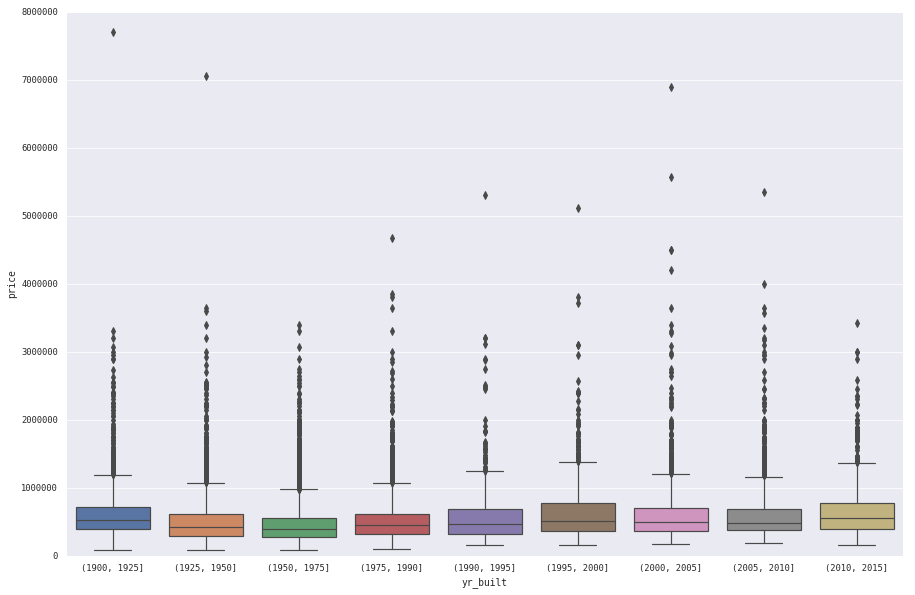

In [56]:
data = pd.concat([kcdata['price'], bins_year], axis=1)
f, ax = plt.subplots(figsize=(15,10))
fig = sns.boxplot(x='yr_built', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

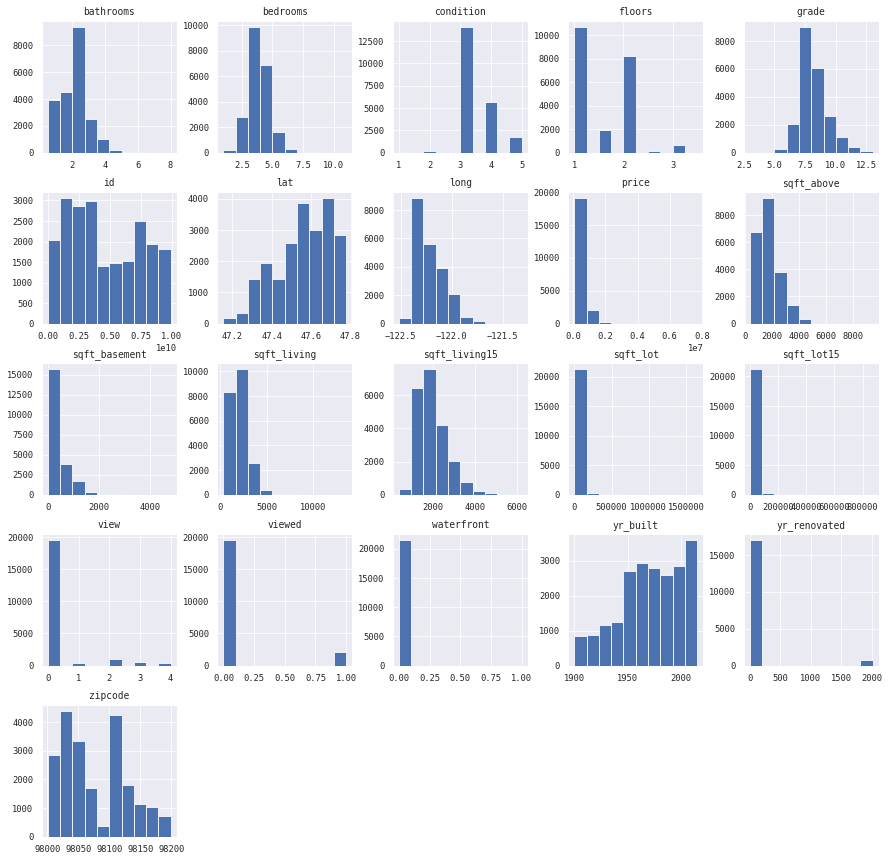

In [57]:
kcdata.hist(figsize=[15,15]);

## Feature Scaling and Normalization

In [58]:
zipcode_dummies = pd.get_dummies(kcdata['zipcode'], prefix='zipcode')
year_dummies=pd.get_dummies(kcdata['yr_built'], prefix='year')

In [59]:
kcdata = pd.concat([kcdata, grade_dummy, floors_dummy, viewed_dummy, bedroom_dummy, bathroom_dummy, condition_dummies, waterfront_dummy, year_dummy, zipcode_dummies], axis=1)

In [60]:
kcdata_set = kcdata.drop(['yr_built', 'yr_renovated', 'grade', 'floors', 'view','sqft_living15','sqft_lot15','viewed', 'zipcode', 'bedrooms','bathrooms','lat','long','condition','waterfront'], axis=1)

In [61]:
kcdata_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Columns: 121 entries, id to zipcode_98199
dtypes: datetime64[ns](1), float64(100), uint8(20)
memory usage: 17.2 MB


In [62]:
kcdata_set.dropna(inplace=True)

 
Variables with lepto kurtosis: price, sqft_lot
Variables with either positive or negative Skewness: sqft_above, sqft_living

We will perform log transformation to variables with skewness and then do mean normalization. 

### Feature transformation and scalling

In [63]:
kcdata_log = pd.DataFrame([])
kcdata_log['sqft_above']=np.log(kcdata_set['sqft_above'])
kcdata_log['sqft_living']=np.log(kcdata_set['sqft_living'])
kcdata_log['price']=np.log(kcdata_set['price'])

In [64]:
basement = kcdata_set['sqft_basement']
lot = kcdata_set['sqft_lot']
logabove = kcdata_log['sqft_above']
logliving = kcdata_log['sqft_living']
logprice = kcdata_log['price']


scaled_basement= (basement - min(basement))/(max(basement) - min(basement))
scaled_lot = (lot - min(lot))/(max(lot) - min(lot))
scaled_above = (logabove - np.mean(logabove))/np.sqrt(np.var(logabove))
scaled_living = (logliving - np.mean(logliving))/np.sqrt(np.var(logliving))
scaled_price = (logprice - np.mean(logprice))/np.sqrt(np.var(logprice))


kcdata_set['price']=scaled_price
kcdata_set['sqft_living']=scaled_living
kcdata_set['sqft_above']=scaled_above
kcdata_set['sqft_lot']=scaled_lot
kcdata_set['sqft_basement']=scaled_basement

In [65]:
kcdata_set.dropna(inplace=True)
kcdata_log.dropna(inplace=True)

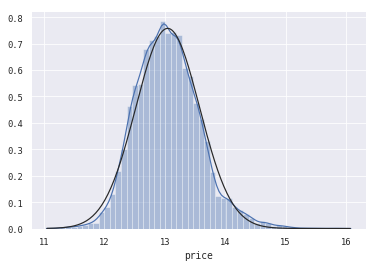

<Figure size 432x288 with 0 Axes>

In [66]:
sns.distplot(kcdata_log['price'], fit=norm)
fig = plt.figure()


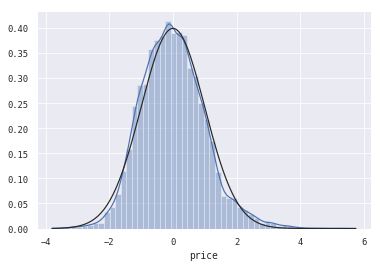

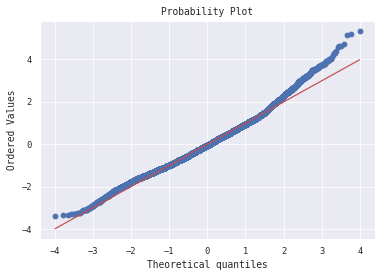

In [67]:
sns.distplot(kcdata_set['price'], fit=norm)
fig=plt.figure()
res = stats.probplot(kcdata_set['price'],plot=plt)

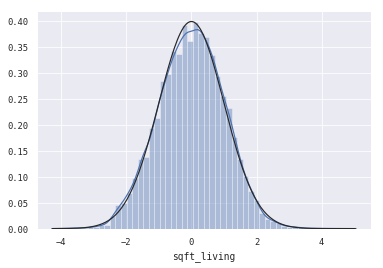

<Figure size 432x288 with 0 Axes>

In [68]:
sns.distplot(kcdata_set['sqft_living'], fit=norm)
fig=plt.figure()

Resources: https://medium.com/vickdata/four-feature-types-and-how-to-transform-them-for-machine-learning-8693e1c24e80

## IV. Model using statsmodels and sklearn

### Simple Linear Regression on area variables

In [69]:
import statsmodels.api as sms
from statsmodels.formula.api import ols

In [70]:
data_ols = kcdata_set.iloc[:,2:]
data_ols.dropna(inplace=True)

In [71]:
data_ols.columns

Index(['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=119)

#### Univariate Regression

In [72]:
X = data_ols.sqft_living
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.806e+04
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:20:52   Log-Likelihood:                -24082.
No. Observations:               21596   AIC:                         4.817e+04
Df Residuals:                   21595   BIC:                         4.817e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living     0.6748      0.005    134.375      0.000       0.665       0.685
==============================================================================
Omnibus:                      123.586   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.131
Skew:                           0.143   Prob(JB):                     1.65e-25
Kurtosis:                       2.788   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
X = data_ols.sqft_basement
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     1599.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:20:52   Log-Likelihood:                -29872.
No. Observations:               21596   AIC:                         5.975e+04
Df Residuals:                   21595   BIC:                         5.975e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_basement     2.4131      0.060     39.988      0.000       2.295       2.531
==============================================================================
Omnibus:                      640.415   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              751.688
Skew:                           0.384   Prob(JB):                    5.93e-164
Kurtosis:                       3.497   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
X = data_ols.sqft_above
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.130e+04
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:20:52   Log-Likelihood:                -26100.
No. Observations:               21596   AIC:                         5.220e+04
Df Residuals:                   21595   BIC:                         5.221e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_above     0.5861      0.006    106.290      0.000       0.575       0.597
==============================================================================
Omnibus:                      138.784   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.468
Skew:                           0.188   Prob(JB):                     5.19e-31
Kurtosis:                       2.883   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The square footage of house apart from basement seems to be significant to house price too. 

#### Let's put all variables into the model and let algorithm decide which variable to keep.

In [75]:
predictors = data_ols.drop('price', axis=1)
X = predictors
y = data_ols['price']

In [76]:
import statsmodels.api as sm
#from statsmodels.formula.api import ols

X_int = sm.add_constant(predictors)

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1415.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:20:52   Log-Likelihood:                -7689.6
No. Observations:               21596   AIC:                         1.561e+04
Df Residuals:                   21483   BIC:                         1.651e+04
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2630      0.072      3.678      0.000       0.123       0.403
sqft_living             0.2615      0.013     19.488      0.000       0.235       0.288
sqft_lot                2.3112      0.104     22.188      0.000       2.107       2.515
sqft_above              0.1656      0.012     13.469      0.000       0.141       0.190
sqft_basement           0.1529      0.072      2.124      0.034       0.012       0.294
grade_3                 0.3574      0.318      1.123      0.261      -0.266       0.981
grade_4                -0.6935      0.071     -9.823      0.000      -0.832      -0.555
grade_5                -0.7630      0.040    -19.133      0.000      -0.841      -0.685
grade_6                -0.6140      0.035    -17.640      0.000      -0.682      -0.546
grade_7                -0.4345      0.034    -12.770      0.000      -0.501      -0.368
grade_8                -0.2583      0.034     -7.597      0.000      -0.325      -0.192
grade_9                -0.0145      0.034     -0.422      0.673      -0.082       0.053
grade_10                0.1932      0.035      5.452      0.000       0.124       0.263
grade_11                0.4436      0.038     11.685      0.000       0.369       0.518
grade_12                0.7324      0.049     14.948      0.000       0.636       0.828
grade_13                1.3141      0.098     13.446      0.000       1.123       1.506
floors_(0.0, 1.0]       0.1767      0.019      9.297      0.000       0.139       0.214
floors_(1.0, 1.5]       0.1068      0.020      5.462      0.000       0.068       0.145
floors_(1.5, 2.0]       0.0659      0.019      3.519      0.000       0.029       0.103
floors_(2.0, 3.5]      -0.0864      0.021     -4.052      0.000      -0.128      -0.045
view_0                 -0.0230      0.036     -0.638      0.524      -0.094       0.048
view_1                  0.2860      0.036      7.934      0.000       0.215       0.357
bedroom_(1, 2]         -0.0792      0.026     -2.995      0.003      -0.131      -0.027
bedroom_(2, 3]         -0.0981      0.027     -3.666      0.000      -0.151      -0.046
bedroom_(3, 4]         -0.1081      0.028     -3.923      0.000      -0.162      -0.054
bedroom_(4, 5]         -0.1475      0.029     -5.080      0.000      -0.204      -0.091
bedroom_(5, 6]         -0.1805      0.035     -5.135      0.000      -0.249      -0.112
bedroom_(6, 11]        -0.3639      0.053     -6.811      0.000      -0.469      -0.259
bathroom_(0.5, 1.5]     0.3208      0.174      1.846      0.065      -0.020       0.661
bathroom_(1.5, 2.0]     0.3468      0.174      1.995      0.046       0.006       0.687
bathroom_(2.0, 2.5]     0.3982      0.174      2.290      0.022       0.057       0.739
bathroom_(2.5, 5.0]     0.4430      0.174      2.546      0.011       0.102       0.784
bat

The adjusted R-square is very high, however, many variables have big p values.

## Use sklearn

#You have to use numerical values in sklearn... has to transform to dummy variables...
https://www.scikit-yb.org/en/latest/api/features/rfecv.html

In [77]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [78]:
predictors = data_ols.drop('price', axis=1)
X = predictors
y = data_ols['price']

linreg = LinearRegression()
selector = RFE(linreg,n_features_to_select=100)
selector = selector.fit(X,y)

In [79]:
data_ols.columns

Index(['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=119)

In [80]:
selector.support_

array([False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [81]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ 3.01565021e+00 -8.71600883e+10 -8.71600883e+10 -8.71600883e+10
 -8.71600883e+10 -8.71600883e+10 -8.71600883e+10 -8.71600883e+10
 -8.71600883e+10 -8.71600883e+10 -8.71600883e+10 -8.71600883e+10
  5.04061214e+10  5.04061214e+10  5.04061214e+10  5.04061214e+10
 -1.84222377e+09 -1.84222377e+09  3.60870361e-01  5.68977356e-01
  7.01080322e-01  8.89175415e-01  1.14394188e+00 -4.26785399e+10
 -4.26785399e+10 -4.26785399e+10 -4.26785399e+10 -4.26785399e+10
 -1.29603320e+08 -1.29603319e+08 -1.97310278e+09 -1.97310278e+09
 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09
 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09
 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09
 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09
 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09
 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09
 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09 -1.97310278e+09
 -1.97310278e+09 -1.97310

In [82]:
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)
selected_columns

Index(['sqft_lot', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13',
       'floors_(0.0, 1.0]', 'floors_(1.0, 1.5]', 'floors_(1.5, 2.0]',
       'floors_(2.0, 3.5]', 'view_0', 'view_1', 'bathroom_(0.5, 1.5]',
       'bathroom_(1.5, 2.0]', 'bathroom_(2.0, 2.5]', 'bathroom_(2.5, 5.0]',
       'bathroom_(5.0, 8.0]', 'con_1', 'con_2', 'con_3', 'con_4', 'con_5',
       'waterfront_0.0', 'waterfront_1.0', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipco

In [83]:
X_int = sm.add_constant(predictors[selected_columns])

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1160.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:21:38   Log-Likelihood:                -11170.
No. Observations:               21596   AIC:                         2.253e+04
Df Residuals:                   21501   BIC:                         2.329e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 2.04e+11   6.24e+11      0.327      0.744   -1.02e+12    1.43e+12
sqft_lot                3.0167      0.121     24.864      0.000       2.779       3.254
grade_3              2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_4              2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_5              2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_6              2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_7              2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_8              2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_9              2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_10             2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_11             2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_12             2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
grade_13             2.058e+10    6.3e+10      0.327      0.744   -1.03e+11    1.44e+11
floors_(0.0, 1.0]    4.246e+10    1.3e+11      0.327      0.744   -2.12e+11    2.97e+11
floors_(1.0, 1.5]    4.246e+10    1.3e+11      0.327      0.744   -2.12e+11    2.97e+11
floors_(1.5, 2.0]    4.246e+10    1.3e+11      0.327      0.744   -2.12e+11    2.97e+11
floors_(2.0, 3.5]    4.246e+10    1.3e+11      0.327      0.744   -2.12e+11    2.97e+11
view_0              -8.151e+10   2.49e+11     -0.327      0.744    -5.7e+11    4.07e+11
view_1              -8.151e+10   2.49e+11     -0.327      0.744    -5.7e+11    4.07e+11
bathroom_(0.5, 1.5]     0.3609      0.204      1.771      0.077      -0.039       0.760
bathroom_(1.5, 2.0]     0.5690      0.204      2.791      0.005       0.169       0.969
bathroom_(2.0, 2.5]     0.7010      0.204      3.438      0.001       0.301       1.101
bathroom_(2.5, 5.0]     0.8891      0.204      4.358      0.000       0.489       1.289
bathroom_(5.0, 8.0]     1.1438      0.215      5.328      0.000       0.723       1.565
con_1                1.633e+10   4.99e+10      0.327      0.744   -8.16e+10    1.14e+11
con_2                1.633e+10   4.99e+10      0.327      0.744   -8.16e+10    1.14e+11
con_3                1.633e+10   4.99e+10      0.327      0.744   -8.16e+10    1.14e+11
con_4                1.633e+10   4.99e+10      0.327      0.744   -8.16e+10    1.14e+11
con_5                1.633e+10   4.99e+10      0.327      0.744   -8.16e+10    1.14e+11
waterfront_0.0       -2.05e+11   6.27e+11     -0.327      0.744   -1.43e+12    1.02e+12
waterfront_1.0       -2.05e+11   6.27e+11     -0.327      0.744   -1.43e+12    1.02e+12
zipcode_98001        3.096e+09   9.47e+09      0.327      0.744   -1.55e+10    2.17e+10
zip

#### The results are still not satisfying with so many insignificant variables. 

#### 

#### Let's try to do some combination: forward selection and then stepwise! 

We know from the data exploration that location and grade are important to price. Let's model them first and select relevant zipcodes.

In [84]:
df = data_ols.filter(regex='zipcode|grade')

In [85]:
df.head()

,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
X = df
y = data_ols['price']

import statsmodels.api as sm

X_int = sm.add_constant(X)

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     923.2
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:22:37   Log-Likelihood:                -14671.
No. Observations:               21596   AIC:                         2.950e+04
Df Residuals:                   21516   BIC:                         3.014e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.363e+11    4.1e+11      0.577      0.564   -5.67e+11    1.04e+12
grade_3       -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_4       -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_5       -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_6       -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_7       -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_8       -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_9       -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_10      -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_11      -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_12      -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
grade_13      -2.443e+11   4.23e+11     -0.577      0.564   -1.07e+12    5.86e+11
zipcode_98001  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98002  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98003  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98004  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98005  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98006  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98007  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98008  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98010  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98011  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98014  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98019  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98022  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98023  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98024  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98027  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98028  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98029  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98030  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98031  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98032  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98033  7.982e+09   1.38e+10      0.577      0.564   -1.91e+10    3.51e+10
zipcode_98034  7.982e+09   1.38e+10      0.577   

### Stepwise Selection

In [87]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [88]:
X = df
y = data_ols['price']

In [89]:
result = stepwise_selection(X, y, verbose = True)
print(result)

Add  grade_11                       with p-value 0.0
Add  grade_10                       with p-value 0.0
Add  grade_9                        with p-value 0.0
Add  grade_8                        with p-value 0.0
Add  grade_12                       with p-value 0.0
Add  grade_7                        with p-value 1.58859e-256
Add  zipcode_98004                  with p-value 1.3098e-206
Add  zipcode_98023                  with p-value 8.62432e-206
Add  zipcode_98042                  with p-value 7.87754e-138
Add  zipcode_98001                  with p-value 4.31994e-136
Add  grade_13                       with p-value 4.88924e-138
Add  zipcode_98092                  with p-value 7.21897e-141
Add  zipcode_98003                  with p-value 4.8009e-134
Add  zipcode_98112                  with p-value 8.40232e-112
Add  zipcode_98040                  with p-value 4.07661e-109
Add  zipcode_98115                  with p-value 7.0388e-109
Add  zipcode_98038                  with p-value 9.00383

We now add sqft_above and year.

In [90]:
result.append('sqft_above')

In [91]:
b = data_ols.filter(like='year')

In [92]:
year_result = stepwise_selection(b, y, verbose=True)
year_result

Add  year_(1950, 1975]              with p-value 1.23151e-106
Add  year_(1925, 1950]              with p-value 3.83108e-52
Add  year_(1975, 1990]              with p-value 6.54131e-49
Add  year_(1990, 1995]              with p-value 3.77943e-09
Add  year_(2010, 2015]              with p-value 3.38282e-06
Add  year_(1995, 2000]              with p-value 0.005541


['year_(1950, 1975]',
 'year_(1925, 1950]',
 'year_(1975, 1990]',
 'year_(1990, 1995]',
 'year_(2010, 2015]',
 'year_(1995, 2000]']

In [93]:
result = result + year_result

In [94]:
data_ols[result];

In [95]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_int = sm.add_constant(data_ols[result])

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1264.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:26:46   Log-Likelihood:                -12303.
No. Observations:               21596   AIC:                         2.476e+04
Df Residuals:                   21519   BIC:                         2.537e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.6098      0.030    -20.336      0.000      -0.669      -0.551
grade_11              1.6865      0.039     42.868      0.000       1.609       1.764
grade_10              1.3167      0.034     38.405      0.000       1.249       1.384
grade_9               1.0115      0.032     31.814      0.000       0.949       1.074
grade_8               0.6879      0.030     22.940      0.000       0.629       0.747
grade_12              2.1841      0.057     38.256      0.000       2.072       2.296
grade_7               0.4441      0.029     15.342      0.000       0.387       0.501
zipcode_98004         1.1933      0.026     46.669      0.000       1.143       1.243
zipcode_98023        -1.0340      0.021    -49.663      0.000      -1.075      -0.993
zipcode_98042        -0.8788      0.020    -43.982      0.000      -0.918      -0.840
zipcode_98001        -1.0087      0.024    -42.120      0.000      -1.056      -0.962
grade_13              2.6855      0.125     21.497      0.000       2.441       2.930
zipcode_98092        -0.9557      0.024    -39.455      0.000      -1.003      -0.908
zipcode_98003        -0.9646      0.027    -35.907      0.000      -1.017      -0.912
zipcode_98112         1.0077      0.028     36.529      0.000       0.954       1.062
zipcode_98040         0.8703      0.027     32.080      0.000       0.817       0.923
zipcode_98115         0.5789      0.020     28.908      0.000       0.540       0.618
zipcode_98038        -0.6881      0.020    -35.210      0.000      -0.726      -0.650
zipcode_98030        -0.9237      0.028    -33.009      0.000      -0.979      -0.869
zipcode_98058        -0.6780      0.022    -31.406      0.000      -0.720      -0.636
zipcode_98031        -0.8413      0.027    -30.921      0.000      -0.895      -0.788
zipcode_98002        -1.0611      0.032    -33.529      0.000      -1.123      -0.999
zipcode_98168        -0.8925      0.028    -32.011      0.000      -0.947      -0.838
zipcode_98198        -0.7944      0.027    -29.485      0.000      -0.847      -0.742
zipcode_98032        -1.0370      0.039    -26.426      0.000      -1.114      -0.960
zipcode_98055        -0.7389      0.027    -26.958      0.000      -0.793      -0.685
zipcode_98022        -0.7525      0.029    -25.684      0.000      -0.810      -0.695
zipcode_98105         0.8596      0.030     28.849      0.000       0.801       0.918
zipcode_98039         1.5371      0.062     24.936      0.000       1.416       1.658
zipcode_98178        -0.6005      0.028    -21.467      0.000      -0.655      -0.546
zipcode_98106        -0.3632      0.025    -14.423      0.000      -0.413      -0.314
zipcode_98188        -0.8044      0.038    -21.321      0.000      -0.878      -0.730
zipcode_98033         0.5295      0.022     24.016      0.000       0.486

The result is pretty good with only one insignificant variable (p> 0.05). Let's try to add bedroom and bathroom too. 

In [96]:
room = data_ols.filter(like='room')

room_result = stepwise_selection(room, y, verbose=True)
room_result

Add  bathroom_(0.5, 1.5]            with p-value 0.0
Add  bathroom_(2.5, 5.0]            with p-value 0.0
Add  bathroom_(1.5, 2.0]            with p-value 7.34652e-105
Add  bathroom_(5.0, 8.0]            with p-value 9.96864e-90
Add  bedroom_(2, 3]                 with p-value 1.33937e-61
Add  bedroom_(1, 2]                 with p-value 4.18004e-22
Add  bedroom_(4, 5]                 with p-value 2.60536e-05
Add  bedroom_(3, 4]                 with p-value 9.54322e-07
Drop bedroom_(1, 2]                 with p-value 0.720551
Add  bedroom_(5, 6]                 with p-value 2.33194e-05
Drop bedroom_(2, 3]                 with p-value 0.136499
Add  bathroom_(2.0, 2.5]            with p-value 0.000451242
Drop bathroom_(0.5, 1.5]            with p-value 0.0602506
Add  bedroom_(1, 2]                 with p-value 0.00897649


['bathroom_(2.5, 5.0]',
 'bathroom_(1.5, 2.0]',
 'bathroom_(5.0, 8.0]',
 'bedroom_(4, 5]',
 'bedroom_(3, 4]',
 'bedroom_(5, 6]',
 'bathroom_(2.0, 2.5]',
 'bedroom_(1, 2]']

In [97]:
result = result + room_result

In [98]:
#Now we have year, room, zipcode, sqft_above, grade
X_int = sm.add_constant(data_ols[result])

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     1219.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:27:13   Log-Likelihood:                -11738.
No. Observations:               21596   AIC:                         2.365e+04
Df Residuals:                   21511   BIC:                         2.432e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.7271      0.030    -24.372      0.000      -0.786      -0.669
grade_11                1.5782      0.039     40.790      0.000       1.502       1.654
grade_10                1.2253      0.034     36.338      0.000       1.159       1.291
grade_9                 0.9287      0.031     29.660      0.000       0.867       0.990
grade_8                 0.6058      0.030     20.462      0.000       0.548       0.664
grade_12                2.0595      0.057     36.187      0.000       1.948       2.171
grade_7                 0.3911      0.028     13.765      0.000       0.335       0.447
zipcode_98004           1.1739      0.025     47.052      0.000       1.125       1.223
zipcode_98023          -1.0388      0.020    -51.173      0.000      -1.079      -0.999
zipcode_98042          -0.8714      0.019    -44.733      0.000      -0.910      -0.833
zipcode_98001          -1.0045      0.023    -43.031      0.000      -1.050      -0.959
grade_13                2.5338      0.125     20.198      0.000       2.288       2.780
zipcode_98092          -0.9399      0.024    -39.795      0.000      -0.986      -0.894
zipcode_98003          -0.9601      0.026    -36.675      0.000      -1.011      -0.909
zipcode_98112           0.9986      0.027     37.104      0.000       0.946       1.051
zipcode_98040           0.8292      0.026     31.309      0.000       0.777       0.881
zipcode_98115           0.5628      0.020     28.793      0.000       0.524       0.601
zipcode_98038          -0.6900      0.019    -36.179      0.000      -0.727      -0.653
zipcode_98030          -0.9254      0.027    -33.918      0.000      -0.979      -0.872
zipcode_98058          -0.6891      0.021    -32.739      0.000      -0.730      -0.648
zipcode_98031          -0.8530      0.027    -32.154      0.000      -0.905      -0.801
zipcode_98002          -1.0714      0.031    -34.723      0.000      -1.132      -1.011
zipcode_98168          -0.8866      0.027    -32.611      0.000      -0.940      -0.833
zipcode_98198          -0.7883      0.026    -30.015      0.000      -0.840      -0.737
zipcode_98032          -1.0283      0.038    -26.878      0.000      -1.103      -0.953
zipcode_98055          -0.7341      0.027    -27.484      0.000      -0.786      -0.682
zipcode_98022          -0.7373      0.029    -25.801      0.000      -0.793      -0.681
zipcode_98105           0.8227      0.029     28.288      0.000       0.766       0.880
zipcode_98039           1.5001      0.060     24.863      0.000       1.382       1.618
zipcode_98178          -0.6373      0.027    -23.357      0.000      -0.691      -0.584
zipcode_98106          -0.3971      0.025    -16.155      0.000      -0.445      -0.349
zipcode_98188          -0.8199      0.037    -22.291      0.000      -0.892      -0.748
zip

Pretty satified with the result already, but let's try adding condition and waterfront just in case! 

In [99]:
water = data_ols.filter(like='waterfront')
condition = data_ols.filter(like='con')


In [100]:
water_result = stepwise_selection(water, y, verbose=True)

Add  waterfront_0.0                 with p-value 6.30509e-141
Add  waterfront_1.0                 with p-value 1.07313e-140


In [101]:
condition_result = stepwise_selection(condition, y, verbose=True)
condition_result

Add  con_2                          with p-value 8.16197e-37
Add  con_5                          with p-value 3.72014e-18
Add  con_3                          with p-value 1.07471e-08
Add  con_1                          with p-value 2.93862e-07


['con_2', 'con_5', 'con_3', 'con_1']

In [102]:
result = result + water_result

In [103]:
#Now we have year, room, zipcode, sqft_above, grade, condition, water
X_int = sm.add_constant(data_ols[result])

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1317.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:27:14   Log-Likelihood:                -10932.
No. Observations:               21596   AIC:                         2.204e+04
Df Residuals:                   21510   BIC:                         2.272e+04
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6.567e+11   7.69e+11      0.854      0.393   -8.51e+11    2.16e+12
grade_11                1.5350      0.037     41.163      0.000       1.462       1.608
grade_10                1.2106      0.033     37.223      0.000       1.147       1.274
grade_9                 0.9347      0.030     30.983      0.000       0.876       0.994
grade_8                 0.6171      0.029     21.634      0.000       0.561       0.673
grade_12                1.9359      0.055     35.196      0.000       1.828       2.044
grade_7                 0.4077      0.027     14.893      0.000       0.354       0.461
zipcode_98004           1.2014      0.024     49.949      0.000       1.154       1.249
zipcode_98023          -1.0362      0.020    -52.983      0.000      -1.075      -0.998
zipcode_98042          -0.8621      0.019    -45.934      0.000      -0.899      -0.825
zipcode_98001          -0.9959      0.022    -44.279      0.000      -1.040      -0.952
grade_13                2.5756      0.121     21.310      0.000       2.339       2.813
zipcode_98092          -0.9291      0.023    -40.830      0.000      -0.974      -0.885
zipcode_98003          -0.9481      0.025    -37.591      0.000      -0.998      -0.899
zipcode_98112           1.0226      0.026     39.426      0.000       0.972       1.073
zipcode_98040           0.8090      0.026     31.700      0.000       0.759       0.859
zipcode_98115           0.5754      0.019     30.553      0.000       0.538       0.612
zipcode_98038          -0.6807      0.018    -37.041      0.000      -0.717      -0.645
zipcode_98030          -0.9180      0.026    -34.925      0.000      -0.970      -0.866
zipcode_98058          -0.6769      0.020    -33.377      0.000      -0.717      -0.637
zipcode_98031          -0.8453      0.026    -33.073      0.000      -0.895      -0.795
zipcode_98002          -1.0635      0.030    -35.775      0.000      -1.122      -1.005
zipcode_98168          -0.8738      0.026    -33.360      0.000      -0.925      -0.822
zipcode_98198          -0.8220      0.025    -32.466      0.000      -0.872      -0.772
zipcode_98032          -1.0188      0.037    -27.641      0.000      -1.091      -0.947
zipcode_98055          -0.7228      0.026    -28.089      0.000      -0.773      -0.672
zipcode_98022          -0.7277      0.028    -26.431      0.000      -0.782      -0.674
zipcode_98105           0.8246      0.028     29.429      0.000       0.770       0.880
zipcode_98039           1.5247      0.058     26.229      0.000       1.411       1.639
zipcode_98178          -0.6717      0.026    -25.499      0.000      -0.723      -0.620
zipcode_98106          -0.3872      0.024    -16.351      0.000      -0.434      -0.341
zipcode_98188          -0.8087      0.035    -22.821      0.000      -0.878      -0.739
zip

In [104]:
final_result = stepwise_selection(data_ols[result], y , verbose=True)

Add  sqft_above                     with p-value 0.0
Add  bathroom_(2.5, 5.0]            with p-value 3.70944e-263
Add  zipcode_98004                  with p-value 7.2189e-222
Add  zipcode_98023                  with p-value 7.11973e-170
Add  zipcode_98042                  with p-value 1.0556e-169
Add  zipcode_98001                  with p-value 7.589e-158
Add  zipcode_98038                  with p-value 4.17568e-153
Add  zipcode_98092                  with p-value 1.16008e-149
Add  waterfront_1.0                 with p-value 6.28592e-150
Add  zipcode_98112                  with p-value 6.29524e-156
Add  waterfront_0.0                 with p-value 2.02749e-158
Add  zipcode_98002                  with p-value 5.13172e-147
Add  zipcode_98040                  with p-value 2.3365e-134
Add  zipcode_98003                  with p-value 1.63379e-129
Add  grade_6                        with p-value 3.57118e-139
Add  grade_7                        with p-value 5.42448e-258
Add  grade_8          

In [105]:
X_int = sm.add_constant(data_ols[final_result])

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1349.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        22:29:55   Log-Likelihood:                -10931.
No. Observations:               21596   AIC:                         2.203e+04
Df Residuals:                   21512   BIC:                         2.270e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6429      0.044     14.769      0.000       0.558       0.728
sqft_above              0.2778      0.005     54.168      0.000       0.268       0.288
bathroom_(2.5, 5.0]     0.3063      0.012     25.328      0.000       0.283       0.330
zipcode_98004           1.2012      0.024     49.961      0.000       1.154       1.248
zipcode_98023          -1.0367      0.020    -53.022      0.000      -1.075      -0.998
zipcode_98042          -0.8625      0.019    -45.967      0.000      -0.899      -0.826
zipcode_98001          -0.9965      0.022    -44.337      0.000      -1.041      -0.952
zipcode_98038          -0.6809      0.018    -37.061      0.000      -0.717      -0.645
zipcode_98092          -0.9303      0.023    -40.937      0.000      -0.975      -0.886
zipcode_98112           1.0234      0.026     39.489      0.000       0.973       1.074
waterfront_0.0         -1.3905      0.034    -40.890      0.000      -1.457      -1.324
zipcode_98002          -1.0646      0.030    -35.847      0.000      -1.123      -1.006
zipcode_98040           0.8094      0.026     31.722      0.000       0.759       0.859
zipcode_98003          -0.9484      0.025    -37.608      0.000      -0.998      -0.899
grade_6                 0.1918      0.026      7.246      0.000       0.140       0.244
grade_7                 0.4091      0.026     15.620      0.000       0.358       0.460
grade_8                 0.6181      0.027     22.562      0.000       0.564       0.672
zipcode_98030          -0.9189      0.026    -34.991      0.000      -0.970      -0.867
zipcode_98058          -0.6768      0.020    -33.379      0.000      -0.717      -0.637
zipcode_98031          -0.8456      0.026    -33.088      0.000      -0.896      -0.795
zipcode_98198          -0.8223      0.025    -32.488      0.000      -0.872      -0.773
zipcode_98168          -0.8742      0.026    -33.397      0.000      -0.926      -0.823
zipcode_98055          -0.7228      0.026    -28.091      0.000      -0.773      -0.672
zipcode_98022          -0.7277      0.028    -26.434      0.000      -0.782      -0.674
zipcode_98032          -1.0191      0.037    -27.653      0.000      -1.091      -0.947
zipcode_98115           0.5760      0.019     30.602      0.000       0.539       0.613
zipcode_98199           0.6902      0.024     28.422      0.000       0.643       0.738
zipcode_98039           1.5250      0.058     26.238      0.000       1.411       1.639
zipcode_98105           0.8255      0.028     29.483      0.000       0.771       0.880
zipcode_98117           0.5492      0.019     28.576      0.000       0.512       0.587
zipcode_98119           0.9124      0.031     29.437      0.000       0.852       0.973
zipcode_98103           0.5344      0.019     28.583      0.000       0.498       0.571
zip

In [128]:
with open('summary.csv', 'w') as fh:
    fh.write(model.summary().as_csv())

Yay!!! The Adj. R-squared is 0.838 and all variables have P value < 0.05. I am very happy with the result now. Let's do some validation! 

## Model-Validation

In [150]:
y = data_ols['price']
X = data_ols[final_result]

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train), len(X_test), len(y_train), len(y_test))

16197 5399 16197 5399


In [152]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [153]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [154]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [155]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.1626631465520761
Test Mean Squarred Error: 0.15757817102871197


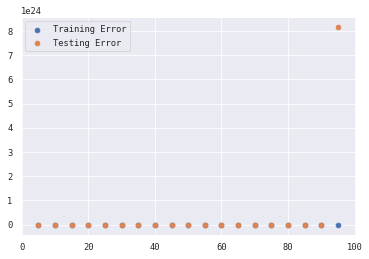

In [156]:
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

We will go with this model now! 

## V. Model Interpretation

In [157]:
len(final_result)

83